# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import json # original json library

import pandas as pd
import logging

from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

import sklearn
import shap

/home/benjamin/anaconda3/envs/cyber/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/benjamin/anaconda3/envs/cyber/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_min

In [2]:
# imports for the AutoEncoder model

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.metrics import precision_recall_curve

2023-06-30 15:08:52.087606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Log set-up

In [3]:
LOG_FILENAME = '/home/benjamin/Folders_Python/Cyber/logs/logfile.log'
LOG_FORMAT = '%(asctime)% -- %(name)s -- %(levelname)s -- %(message)s'
# LOG_LEVEL = logging.INFO

In [4]:
# specific logger for the module
logger = logging.getLogger(__name__)   # creates specific logger for the module
logger.setLevel(logging.DEBUG)    # entry level of messages from all handlers
LOG_FORMAT = '%(asctime)s -- %(name)s -- %(levelname)s -- %(message)s'
formatter = logging.Formatter(LOG_FORMAT)

# file handler to log everything
file_handler = logging.FileHandler(LOG_FILENAME, mode='w')
file_handler.setLevel(logging.INFO)  # all messages (DEBUG and up) get logged in the file
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# stream handler to show messages to the console
console = logging.StreamHandler()
console.setLevel(logging.WARNING)  # Warning messages and up get displayed to the console
console.setFormatter(formatter)
logger.addHandler(console)

# start your engine
logger.info("-------- new run --------")

# Import pcap file

In [5]:
# NB : tshark -r <file>.pcap -T json > <file_pcap>.json -t r
# commande shell qui prend un pcap et le passe en json

!rm /home/benjamin/Folders_Python/Cyber/data/outputs/input_pcap.json
# !tshark -r /home/benjamin/Folders_Python/Cyber/data/input_pcaps/input.pcap -T json -t r > /home/benjamin/Folders_Python/Cyber/data/outputs/input_pcap.json

#------------------------------------------------------------------------------------------------------------
#-- NB : On passe par le JSON depuis le pcap pour parser les paquets et créer la df 'raw packets' 
#-- A RE ECRIRE CAR ABSOLUMENT PAS OPTIMAL !!  UTILISER pyshark
#------------------------------------------------------------------------------------------------------------

# logger.info("run tshark to create json translation of input.pcap")

rm: cannot remove '/home/benjamin/Folders_Python/Cyber/data/outputs/input_pcap.json': No such file or directory


In [6]:
class Packet():
    """Utility self-made unperfect class to parse the json object and extract features from a packet-like dict
    """
    
    def __init__(self, raw_packet:dict) -> None:
        self.raw_packet = raw_packet
        self._packet_data = None
        # logger.debug('constructor of Packet instance has finished')
        
    @property
    def packet_data(self):
        # returns the full dictionnary of features
        if self._packet_data is not None:
            return self._packet_data
        else:
            sl = self.raw_packet.get('_source').get('layers')
            slf = sl.get('frame')
            sle = sl.get('eth')
            sli = sl.get('ip', {})  # return empty dict as default not found value so it can handle another get method
            slu = sl.get('udp', {})
            slt = sl.get('tcp', {})
                                               
            self._packet_data = {
                'frame_time' : slf.get('frame.time'),
                'frame_time_relative' : slf.get('frame.time_relative'),
                'frame_length' : slf.get("frame.len"),
                'frame_protocols' : slf.get("frame.protocols"),
                'eth_source': sle.get("eth.src"),
                'eth_dest': sle.get("eth.dst") ,
                'ip_version': sli.get("ip.version"),
                'ip_header_length': sli.get("ip.hdr_len"),
                'ip_length': sli.get("ip.len"),
                'ip_id': sli.get("ip.id"),
                'ip_flags': sli.get("ip.flags"),
                'ip_ttl': sli.get("ip.ttl"),
                'ip_proto': sli.get("ip.proto"),
                'ip_source': sli.get("ip.src"),
                'ip_dest': sli.get("ip.dst"),
                'udp_source_port': slu.get("udp.srcport"),
                'udp_dest_port': slu.get("udp.port"),
                'udp_length': slu.get("udp.length"),
                'tcp_source_port': slt.get("tcp.srcport"),
                'tcp_dest_port': slt.get("tcp.dstport"),
                'tcp_length': slt.get("tcp.len"),
                'tcp_flags': slt.get("tcp.flags"),
            }
            # logger.debug('packet_data @property method has finished')
            return self._packet_data
        
    @packet_data.setter
    def packet_data(self, input):
        """illegal attempt to write packet_data"""
        logger.warning('Illegal attempt to write a data_packet in a packet object')
        pass

In [7]:
# PCAP_FILENAME = "/home/benjamin/Folders_Python/Cyber/data/outputs/input_pcap.json"

# with open (PCAP_FILENAME, errors='replace') as raw_packets:  # NB : errors='replace' bypasses decoding errors
#     json_object = json.load(raw_packets)    # load le fichier json dans une structure Python (list of dicts)

In [8]:
# Exemple : premier dict de la liste : c'est un paquet (=une frame Ethernet)

# json_object[0]

In [9]:
# exemple d'instanciation d'un objet Packet
# p = Packet(json_object[0])

# p.packet_data

# Produce DataFrame for Raw Packets analysis

In [10]:
# créé la liste de dictionnaires des data des objets Packets
# packets = [ Packet(d).packet_data for d in json_object ]

# df_packets = pd.DataFrame(packets)

# df_packets

In [11]:
# df_packets.describe(include='all').transpose()

# EVE JSON Output by Suricata

In [12]:
# run Suricata to produce an eve.json file with alerts

!rm /home/benjamin/Folders_Python/Cyber/data/outputs/eve.json
!suricata -r /home/benjamin/Folders_Python/Cyber/data/input_pcaps/input.pcap -l /home/benjamin/Folders_Python/Cyber/data/outputs -k none
# !suricata -r /home/benjamin/Folders_Python/Cyber/data/input_pcaps/bigFlows.pcap -l /home/benjamin/Folders_Python/Cyber/data/outputs -k none

logger.info("run Suricata to reassemble flows and create alert logs")

30/6/2023 -- 15:08:58 - <Info> - Configuration node 'af-packet' redefined.
30/6/2023 -- 15:08:58 - <Notice> - This is Suricata version 6.0.1 RELEASE running in USER mode
30/6/2023 -- 15:10:11 - <Warning> - [ERRCODE: SC_ERR_INITIALIZATION(45)] - Unix socket: UNIX socket bind(/var/run/suricata-command.socket) error: Address already in use
30/6/2023 -- 15:10:11 - <Warning> - [ERRCODE: SC_ERR_INITIALIZATION(45)] - Unable to create unix command socket
30/6/2023 -- 15:10:11 - <Notice> - all 5 packet processing threads, 4 management threads initialized, engine started.
30/6/2023 -- 15:10:28 - <Notice> - Signal Received.  Stopping engine.
30/6/2023 -- 15:10:30 - <Notice> - Pcap-file module read 1 files, 791615 packets, 355417784 bytes


In [13]:
# Pandas provides a useful method – json_normalize – for normalizing nested JSON fields into dataframe. Resulting columns use dot notation to signify nested objects, similar to how Elasticsearch does it

SURICATA_EVE_LOG = "/home/benjamin/Folders_Python/Cyber/data/outputs/eve.json"

with open (SURICATA_EVE_LOG) as packets:
    df_log = pd.json_normalize(
        [json.loads(packet) for packet in packets],
        max_level=1
    )

In [14]:
df_log

,timestamp,flow_id,pcap_cnt,event_type,src_ip,src_port,dest_ip,dest_port,proto,community_id,...,fileinfo.start,fileinfo.end,ftp.reply,ftp.reply_received,ftp.command,ftp.command_data,ftp.completion_code,tcp.cwr,response_icmp_type,response_icmp_code
0,2013-02-26T23:02:36.058887+0100,2.354798e+13,194.0,dns,172.16.133.6,63229.0,8.8.8.8,53.0,UDP,1:AyH5HOOHZJPTvlg9DZtiTQwszaY=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-26T23:02:36.155638+0100,1.528696e+15,419.0,tls,172.16.133.109,49453.0,96.43.146.22,443.0,TCP,1:+IH4ivvIvUsUtl1biGdMg/iC2v4=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-02-26T23:02:36.267673+0100,1.008032e+15,703.0,http,172.16.133.132,50395.0,76.13.6.174,80.0,TCP,1:kV+oFT44cc2cZUuF0V95umHVwPE=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-02-26T23:02:36.267673+0100,1.008032e+15,703.0,fileinfo,76.13.6.174,80.0,172.16.133.132,50395.0,TCP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-02-26T23:02:36.322376+0100,2.354798e+13,877.0,dns,172.16.133.6,63229.0,8.8.8.8,53.0,UDP,1:AyH5HOOHZJPTvlg9DZtiTQwszaY=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49887,2013-02-26T23:07:35.952999+0100,7.036410e+14,NaN,flow,172.16.133.207,56078.0,172.16.139.250,5440.0,TCP,1:CWqM8uVbIdwmGfYVqrdEFtw8/5M=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49888,2013-02-26T23:07:35.952999+0100,7.036689e+14,NaN,flow,172.16.128.169,4323.0,172.16.133.254,161.0,UDP,1:2L74L9dw6tfxkbIfrADGxJdZELE=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49889,2013-02-26T23:07:35.952999+0100,4.221983e+14,NaN,flow,172.16.133.29,61087.0,208.111.161.254,80.0,TCP,1:4S3EVARcDWoM9/eTjwGhcCm/PTE=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49890,2013-02-26T23:07:35.952999+0100,1.266634e+15,NaN,flow,172.16.133.41,53318.0,172.16.139.250,5440.0,TCP,1:B9ovju3QpuiFTJlGUg0wIe16f6Y=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_log[df_log['event_type']=='flow']

,timestamp,flow_id,pcap_cnt,event_type,src_ip,src_port,dest_ip,dest_port,proto,community_id,...,fileinfo.start,fileinfo.end,ftp.reply,ftp.reply_received,ftp.command,ftp.command_data,ftp.completion_code,tcp.cwr,response_icmp_type,response_icmp_code
2919,2013-02-26T23:02:35.953172+0100,1.554171e+15,NaN,flow,172.16.133.109,49151.0,4.69.134.137,49562.0,UDP,1:O3+oBof8okTF6BSb2srOcuyCq7o=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3124,2013-02-26T23:02:35.953172+0100,1.311265e+15,NaN,flow,fe80:0000:0000:0000:c945:86bb:6ff4:f124,NaN,ff02:0000:0000:0000:0000:0000:0000:0016,NaN,IPv6-ICMP,1:1vUgQW3mqHDbjJ8wrs7HzcsxU+E=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3545,2013-02-26T23:02:35.953172+0100,1.485357e+15,NaN,flow,172.16.133.109,49151.0,4.69.134.154,49770.0,UDP,1:/BczHyX01iEvye097AMMGUZfaW8=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3661,2013-02-26T23:02:35.953172+0100,1.226929e+15,NaN,flow,172.16.128.202,53.0,172.16.133.153,36608.0,UDP,1:a62gxn5n/ACnhXNvQ2MHZeFDJMM=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3662,2013-02-26T23:02:35.953172+0100,9.010656e+14,NaN,flow,fe80:0000:0000:0000:ca2a:14ff:fe4c:30e9,5353.0,ff02:0000:0000:0000:0000:0000:0000:00fb,5353.0,UDP,1:i5G14cOEL0P6PSEFQoztrr7jMcQ=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49886,2013-02-26T23:07:35.952999+0100,4.221510e+14,NaN,flow,172.16.133.69,50747.0,64.94.18.131,80.0,TCP,1:8fb+e8v5M8DD4PoiKVo3VJDp8EM=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49887,2013-02-26T23:07:35.952999+0100,7.036410e+14,NaN,flow,172.16.133.207,56078.0,172.16.139.250,5440.0,TCP,1:CWqM8uVbIdwmGfYVqrdEFtw8/5M=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49888,2013-02-26T23:07:35.952999+0100,7.036689e+14,NaN,flow,172.16.128.169,4323.0,172.16.133.254,161.0,UDP,1:2L74L9dw6tfxkbIfrADGxJdZELE=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49889,2013-02-26T23:07:35.952999+0100,4.221983e+14,NaN,flow,172.16.133.29,61087.0,208.111.161.254,80.0,TCP,1:4S3EVARcDWoM9/eTjwGhcCm/PTE=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Produce DataFrame for Flow Analysis

In [16]:
# from Suricata doc :

# 15.1.2.12. Event type: Flow
# 15.1.2.12.1. Fields

#     “pkts_toserver”: total number of packets to server, include bypassed packets
#     “pkts_toclient”: total number of packets to client
#     “bytes_toserver”: total bytes count to server
#     “bytes_toclient”: total bytes count to client
#     “bypassed.pkts_toserver”: number of bypassed packets to server
#     “bypassed.pkts_toclient”: number of bypassed packets to client
#     “bypassed.bytes_toserver”: bypassed bytes count to server
#     “bypassed.bytes_toclient”: bypassed bytes count to client
#     “start”: date of start of the flow
#     “end”: date of end of flow (last seen packet)
#     “age”: duration of the flow
#     “bypass”: if the flow has been bypassed, it is set to “local” (internal bypass) or “capture”
#     “state”: display state of the flow (include “new”, “established”, “closed”, “bypassed”)
#     “reason”: mechanism that did trigger the end of the flow (include “timeout”, “forced” and “shutdown”)
#     “alerted”: “true” or “false” depending if an alert has been seen on flow

In [17]:
# https://www.stamus-networks.com/blog/jupyter-playbooks-for-suricata-part-1

# https://malware-traffic-analysis.net/

In [18]:
class Flow():
    """Utility class - takes a event-flow string out of eve.json,
       creates a one-level dict structure, suitable for dataframe creation
    """
    def __init__(self, flow_event:dict):
        if flow_event.get('event_type') != 'flow':
            logger.critical("Attempt to build a Flow instance with a non-flow event")
            raise ValueError
        self._raw_flow_event = flow_event
        self._features = None
        
    @property
    def features(self):
        if self._features is not None:
            return self._features
        else:
            keys_list_first_level = [
                'timestamp',
                'flow_id',
                'src_ip',
                'src_port',
                'dest_ip',
                'dest_port',
                'proto'
            ]
            keys_list_second_level = [
                'pkts_toserver',
                'pkts_toclient',
                'bytes_toserver',
                'bytes_toclient',
                'start',
                'end',
                'age',
                'state',
                'reason',
                'alerted'
            ]
            d1 = { k: self._raw_flow_event.get(k) for k in keys_list_first_level }
            d2 = { k: self._raw_flow_event.get('flow').get(k) for k in keys_list_second_level }
            self._features = { **d1, **d2 }
            # logger.info("built a Flow features object")
            return self._features
        
    @features.setter
    def features(self, input):
        logger.critical("illegal attempt to hard write features in a Flow object")
        
    def __str__(self) -> str:
        return json.dumps(self.features, indent=4)
    
    def __repr__(self) -> str:
        return json.dumps(self.features, indent=4)


In [19]:
# exemple de flow JSON = 
# {
# "timestamp":"2023-06-17T10:46:05.765744+0200",
# "flow_id":860724109937755,
# "event_type":"flow",
# "src_ip":"2a01:cb19:872e:3000:0e4f:3187:540c:d66c",
# "src_port":47864,
# "dest_ip":"2a00:1450:4007:081a:0000:0000:0000:2003",
# "dest_port":80,
# "proto":"TCP",
# "flow":
#     {"pkts_toserver":6,
#     "pkts_toclient":5,
#     "bytes_toserver":516,
#     "bytes_toclient":430,
#     "start":"2023-06-17T10:46:10.625755+0200",
#     "end":"2023-06-17T10:46:44.150502+0200",
#     "age":34,
#     "state":"new",
#     "reason":"shutdown",
#     "alerted":true},
# "community_id":"1:uRhWV544zvWeIohZCmryZHXZ5EA=",
# "tcp":
#     {"tcp_flags":"00",
#     "tcp_flags_ts":"00",
#     "tcp_flags_tc":"00"
#     }
# }'

In [20]:
SURICATA_EVE_LOG = "/home/benjamin/Folders_Python/Cyber/data/outputs/eve.json"

i=0
columns_names =  [
                'timestamp',
                'flow_id',
                'src_ip',
                'src_port',
                'dest_ip',
                'dest_port',
                'proto'
            ] + [
                'pkts_toserver',
                'pkts_toclient',
                'bytes_toserver',
                'bytes_toclient',
                'start',
                'end',
                'age',
                'state',
                'reason',
                'alerted'
            ]
dict_for_dataframe = { k:[] for k in columns_names }

with open (SURICATA_EVE_LOG) as f:
    for event_string in f:
        python_object = json.loads(event_string)
        if python_object.get('event_type')=='flow':
            flow = Flow(python_object)
            for k in columns_names:
                if dict_for_dataframe[k] == []:
                    dict_for_dataframe[k] = [flow.features.get(k)]
                else:
                    dict_for_dataframe[k].append(flow.features.get(k))

In [21]:
df_flow = pd.DataFrame(data=dict_for_dataframe)

In [22]:
df_flow

,timestamp,flow_id,src_ip,src_port,dest_ip,dest_port,proto,pkts_toserver,pkts_toclient,bytes_toserver,bytes_toclient,start,end,age,state,reason,alerted
0,2013-02-26T23:02:35.953172+0100,1554171245720378,172.16.133.109,49151.0,4.69.134.137,49562.0,UDP,1,0,1514,0,2013-02-26T23:02:45.619322+0100,2013-02-26T23:02:45.619322+0100,0,new,timeout,False
1,2013-02-26T23:02:35.953172+0100,1311265075391853,fe80:0000:0000:0000:c945:86bb:6ff4:f124,NaN,ff02:0000:0000:0000:0000:0000:0000:0016,NaN,IPv6-ICMP,1,0,130,0,2013-02-26T23:02:46.879981+0100,2013-02-26T23:02:46.879981+0100,0,new,timeout,False
2,2013-02-26T23:02:35.953172+0100,1485357279927441,172.16.133.109,49151.0,4.69.134.154,49770.0,UDP,1,0,1514,0,2013-02-26T23:02:48.580753+0100,2013-02-26T23:02:48.580753+0100,0,new,timeout,False
3,2013-02-26T23:02:35.953172+0100,1226929097239722,172.16.128.202,53.0,172.16.133.153,36608.0,UDP,1,1,85,113,2013-02-26T23:02:41.289962+0100,2013-02-26T23:02:41.290123+0100,0,new,timeout,False
4,2013-02-26T23:02:35.953172+0100,901065633703111,fe80:0000:0000:0000:ca2a:14ff:fe4c:30e9,5353.0,ff02:0000:0000:0000:0000:0000:0000:00fb,5353.0,UDP,1,0,426,0,2013-02-26T23:02:44.730311+0100,2013-02-26T23:02:44.730311+0100,0,new,timeout,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28029,2013-02-26T23:07:35.952999+0100,422151011127328,172.16.133.69,50747.0,64.94.18.131,80.0,TCP,20,10,1510,910,2013-02-26T23:02:55.086048+0100,2013-02-26T23:07:29.330125+0100,274,new,shutdown,False
28030,2013-02-26T23:07:35.952999+0100,703641031985958,172.16.133.207,56078.0,172.16.139.250,5440.0,TCP,10,0,1022,0,2013-02-26T23:05:54.052006+0100,2013-02-26T23:05:54.067194+0100,0,new,shutdown,False
28031,2013-02-26T23:07:35.952999+0100,703668945541593,172.16.128.169,4323.0,172.16.133.254,161.0,UDP,1,1,117,130,2013-02-26T23:04:57.317913+0100,2013-02-26T23:04:57.326963+0100,0,established,shutdown,False
28032,2013-02-26T23:07:35.952999+0100,422198265717538,172.16.133.29,61087.0,208.111.161.254,80.0,TCP,11,17,2355,12506,2013-02-26T23:05:27.729890+0100,2013-02-26T23:06:07.045723+0100,40,closed,shutdown,False


# Some Machine Learning

In [23]:
df_flow.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
timestamp,28034,4566,2013-02-26T23:07:35.947295+0100,18250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flow_id,28034.0,NaN,NaN,NaN,1127860399604030.25,652711525102041.25,41624410288.0,565733918783491.75,1129840287876205.0,1692570674166035.0,2251731929555433.0
src_ip,28034,389,172.16.128.169,1359,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src_port,27824.0,NaN,NaN,NaN,51850.32073,16114.658983,22.0,52386.75,56118.5,60580.0,65534.0
dest_ip,28034,1651,172.16.139.250,13184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dest_port,27824.0,NaN,NaN,NaN,6746.316238,13557.475365,7.0,161.0,5440.0,5440.0,65531.0
proto,28034,4,TCP,22569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pkts_toserver,28034.0,NaN,NaN,NaN,17.311657,212.799352,1.0,4.0,10.0,12.0,25733.0
pkts_toclient,28034.0,NaN,NaN,NaN,10.872548,157.336968,0.0,0.0,0.0,2.0,14980.0
bytes_toserver,28034.0,NaN,NaN,NaN,5677.227652,183705.4693,60.0,246.0,1022.0,1142.0,17342134.0


In [24]:
df_flow.dtypes

timestamp          object
flow_id             int64
src_ip             object
src_port          float64
dest_ip            object
dest_port         float64
proto              object
pkts_toserver       int64
pkts_toclient       int64
bytes_toserver      int64
bytes_toclient      int64
start              object
end                object
age                 int64
state              object
reason             object
alerted              bool
dtype: object

In [25]:
df = df_flow.copy(deep=True)

In [26]:
# codage en ordinal

df['src_ip_ord'], uniques_src_ip = pd.factorize(values=df['src_ip'])
df['dest_ip_ord'], uniques_dest_ip = pd.factorize(values=df['dest_ip'])
df['proto_ord'], uniques_proto = pd.factorize(values=df['proto'])

In [27]:
# Flows flagged as 'alerted' by Suricata

df[df['alerted']==True]

,timestamp,flow_id,src_ip,src_port,dest_ip,dest_port,proto,pkts_toserver,pkts_toclient,bytes_toserver,bytes_toclient,start,end,age,state,reason,alerted,src_ip_ord,dest_ip_ord,proto_ord
763,2013-02-26T23:04:24.100952+0100,803567730613153,172.16.133.41,52875.0,199.204.31.89,80.0,TCP,4,3,1879,238,2013-02-26T23:03:14.449441+0100,2013-02-26T23:03:19.190965+0100,5,closed,timeout,True,27,117,3
1200,2013-02-26T23:04:37.194998+0100,1197210070888691,172.16.133.113,55584.0,172.16.139.250,5462.0,TCP,10,0,696,0,2013-02-26T23:02:39.995571+0100,2013-02-26T23:02:40.500207+0100,1,new,unknown,True,118,23,3
1211,2013-02-26T23:04:37.417619+0100,812658029973744,172.16.133.163,3529.0,4.23.40.126,80.0,TCP,5,4,306,1082,2013-02-26T23:03:31.086256+0100,2013-02-26T23:03:50.211194+0100,19,closed,timeout,True,26,259,3
1519,2013-02-26T23:04:47.953427+0100,2168828310650276,172.16.133.20,62316.0,208.111.160.6,80.0,TCP,31,53,3290,70044,2013-02-26T23:02:48.130468+0100,2013-02-26T23:03:22.020945+0100,34,closed,timeout,True,32,132,3
1570,2013-02-26T23:04:49.339915+0100,1485881265800554,172.16.133.28,65291.0,208.111.161.254,80.0,TCP,22,34,3070,41794,2013-02-26T23:02:46.050538+0100,2013-02-26T23:03:25.617068+0100,39,closed,unknown,True,36,145,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24540,2013-02-26T23:07:35.947295+0100,246207686383004,172.16.133.113,55671.0,172.16.139.250,5462.0,TCP,10,0,696,0,2013-02-26T23:05:36.726428+0100,2013-02-26T23:05:37.235434+0100,1,new,shutdown,True,118,23,3
24688,2013-02-26T23:07:35.947295+0100,1514189407264232,172.16.133.113,55677.0,172.16.139.250,5462.0,TCP,10,0,696,0,2013-02-26T23:05:50.335336+0100,2013-02-26T23:05:50.848017+0100,0,new,shutdown,True,118,23,3
24839,2013-02-26T23:07:35.947295+0100,1374800526297129,172.16.133.67,55907.0,173.194.43.0,443.0,TCP,156,375,15618,520283,2013-02-26T23:02:41.772137+0100,2013-02-26T23:06:44.468036+0100,243,closed,shutdown,True,56,496,3
26646,2013-02-26T23:07:35.952999+0100,547469576571378,172.16.133.113,55665.0,172.16.139.250,5462.0,TCP,10,0,696,0,2013-02-26T23:05:23.133618+0100,2013-02-26T23:05:23.639996+0100,0,new,shutdown,True,118,23,3


### PCA

In [28]:
columns_names = ['src_port', 'dest_port', 'pkts_toserver', 'pkts_toclient', 'bytes_toserver', 'bytes_toclient', 'age', 'src_ip_ord', 'dest_ip_ord', 'proto_ord', 'alerted']
features_names = ['src_port', 'dest_port', 'pkts_toserver', 'pkts_toclient', 'bytes_toserver', 'bytes_toclient', 'age', 'src_ip_ord', 'dest_ip_ord', 'proto_ord']

df_clean = df[columns_names].dropna()

X = df_clean[features_names].to_numpy()
y = df_clean['alerted'].to_numpy()

In [29]:
pca = PCA(n_components=3)  # scikit learn trick : when 0 < n_components < 1, choose the number of components so that the explained variance is above 90%

X_new = pca.fit_transform(X)

print(pca.explained_variance_ratio_)

[0.67840025 0.31286236 0.00562019]


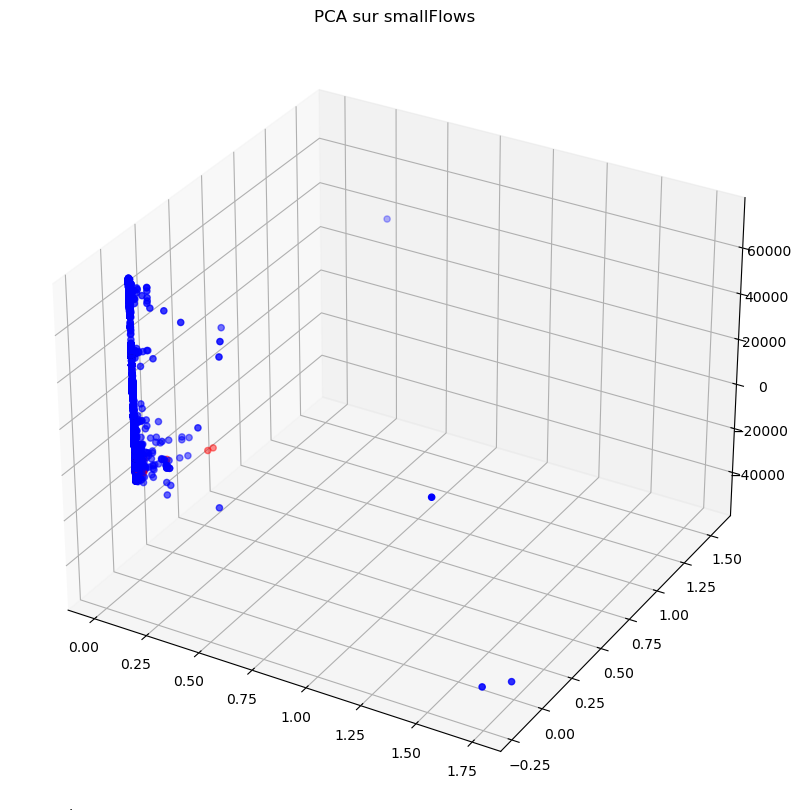

In [30]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

xs = X_new[:,0]
ys = X_new[:,1]
zs = X_new[:,2]

colors = [ 'red' if c == True else 'blue' for c in list(y)]

ax.scatter3D(xs, ys, zs, c=colors)
ax.set_title("PCA sur smallFlows")
plt.show()

### Classifiers

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [32]:
# X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.5, random_state=42)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
train_idx, test_idx = next(sss.split(X, y))
X_train = X[train_idx]
X_test =X[test_idx]
Y_train = y[train_idx]
Y_test = y[test_idx]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
# Vérification du split

n_pos_full = len(df[df["alerted"]==True])
n_neg_full = len(df[df["alerted"]==False])

print(f"Full dataset : there are {n_pos_full} alerts, and {n_neg_full} benign, ie {n_pos_full/(n_pos_full+n_neg_full)*100:.2f}%")

n_pos_train = np.sum(Y_train)
n_neg_train = len(Y_train) - n_pos_train
print(f"Training dataset : {n_pos_train} pos, {len(Y_train)} total, {n_pos_train/(n_neg_train+n_pos_train)*100:.2f}%")

n_pos_test = np.sum(Y_test)
n_neg_test = len(Y_test) - n_pos_test
print(f"Test dataset : {n_pos_test} pos, {len(Y_test)} total, {n_pos_test/(n_neg_test+n_pos_test)*100:.2f}%")

Full dataset : there are 108 alerts, and 27926 benign, ie 0.39%
Training dataset : 54 pos, 13912 total, 0.39%
Test dataset : 54 pos, 13912 total, 0.39%


### A couple of classifiers : Logistic Regression, SVM Linear, Random Forest

In [34]:
clf_lr = sklearn.linear_model.LogisticRegression(random_state=42, max_iter=1000)
clf_lr.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [35]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability=True)
clf_svm.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [36]:
clf_rf = sklearn.ensemble.RandomForestClassifier()
clf_rf.fit(X_train, Y_train)

RandomForestClassifier()

In [37]:
models = {
    "Logistic_Regression" : clf_lr,
    "SVM_linear_kernel" : clf_svm,
    "Random_Forest" : clf_rf
}

In [38]:
roc_curve_params = {}

Accuracy of Logistic_Regression = 99.58%


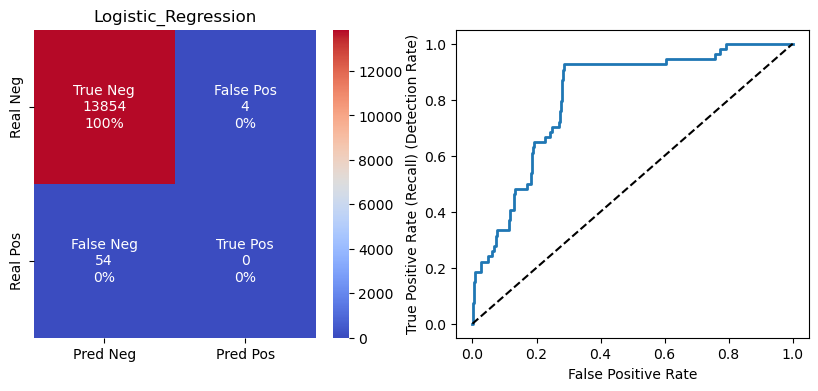

Accuracy of SVM_linear_kernel = 99.61%


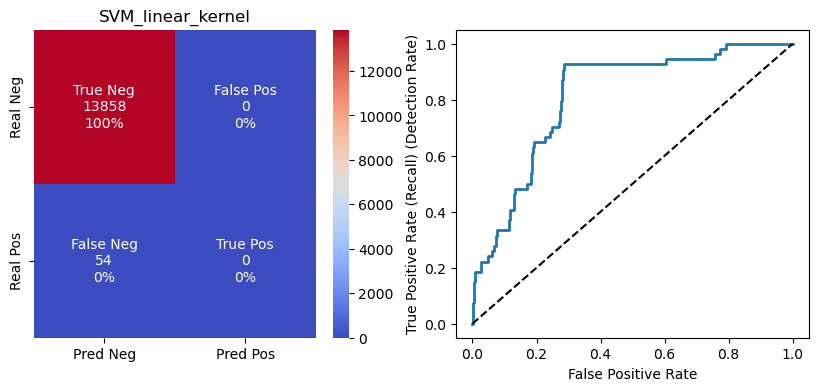

Accuracy of Random_Forest = 99.82%


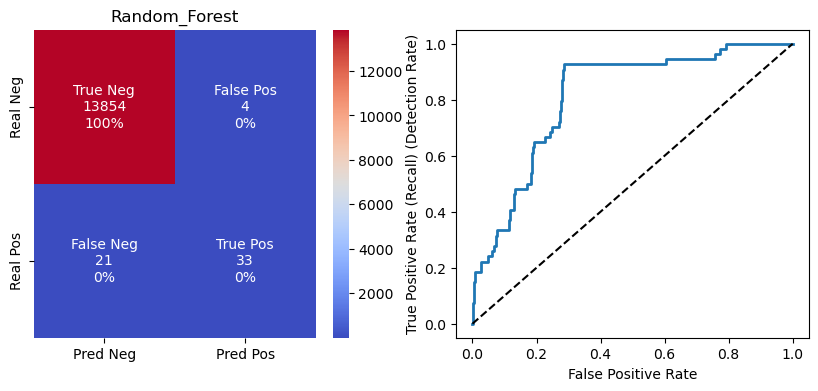

In [39]:
for name, model in models.items():
    print(f"Accuracy of {name} = {model.score(X_test, Y_test)*100:.2f}%")

    Y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(Y_test, Y_pred)

    # print(cf_matrix)

    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = [ f'{value:0}' for value in cf_matrix.flatten()]
    group_percentages = [f'{value*100:.0f}%' for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [ f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages) ]
    labels = np.asarray(labels).reshape(2,2)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="coolwarm", center = np.sum(cf_matrix)/2, xticklabels=["Pred Neg", "Pred Pos"], yticklabels=["Real Neg", "Real Pos"], ax=ax[0])
    ax[0].set_title(name)

    Y_scores = cross_val_predict(clf_lr, X_test, Y_test, cv=3, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(Y_test, Y_scores[:,1])
    
    roc_curve_params[name] = [ fpr, tpr, thresholds ]

    # fig, ax = plt.subplots()

    ax[1].plot(fpr, tpr, linewidth=2)
    ax[1].plot([0,1], [0,1], 'k--')
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate (Recall) (Detection Rate)")
    plt.show()

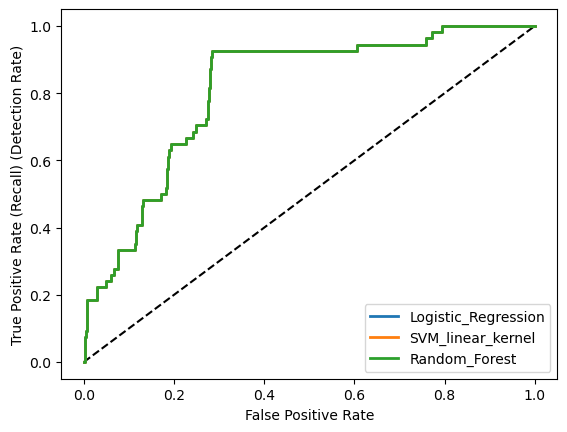

In [40]:
fig, ax = plt.subplots()
    
ax.plot([0,1], [0,1], 'k--')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate (Recall) (Detection Rate)")
    
for name, list_params in roc_curve_params.items():
    ax.plot(list_params[0], list_params[1], linewidth=2, label=name)

ax.legend()  
plt.show()

## Explainability

### PCA

In [41]:
# expression of the eigen vectors in the features space

pca.components_

array([[-2.12222779e-03,  1.80286672e-03,  1.04226003e-03,
         6.18626681e-04,  9.88653292e-01,  1.50184693e-01,
         3.34202824e-05,  8.19395888e-06,  4.62626325e-05,
         1.63190334e-08],
       [-1.72106641e-03,  2.42033377e-04,  2.26307192e-04,
         6.91868056e-04, -1.50189825e-01,  9.88655369e-01,
         3.92440909e-05,  9.33684911e-06,  1.57683701e-04,
         1.74446134e-07],
       [-8.93374974e-01,  4.49248011e-01,  9.16711639e-05,
         1.27394403e-04, -2.42826678e-03, -2.03528552e-03,
         2.44511386e-04,  3.83023929e-04,  6.86353895e-03,
        -3.28410301e-05]])

### SHAP

In [42]:
shap.initjs()

explainer = shap.KernelExplainer(clf_rf.predict_proba, X_test[:100])
shap_values = explainer.shap_values(X_test[:100])
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

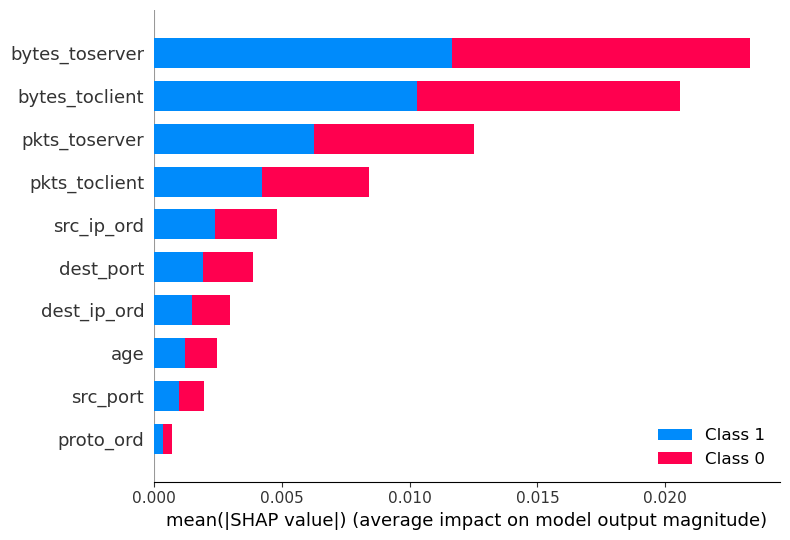

In [43]:
shap.summary_plot(shap_values, X_test, feature_names=features_names)

### AutoEncoder

In [83]:
# set seed for reproducibility
tf.random.set_seed(42)

In [84]:
# extract flows without alert to train the AE
X_train_neg = np.array([ X_train[i] for i in range(len(X_train)) if Y_train[i]==False ])

In [85]:
# model

input_dim = X_train_neg.shape[1]  # number of features
encoding_dim = 256
hidden_dim = 16

inputs = tf.keras.layers.Input(shape=(input_dim,))
x = tf.keras.layers.Dense(units=encoding_dim, activation='relu')(inputs)
x = tf.keras.layers.Dense(units=hidden_dim, activation='relu')(x)
x = tf.keras.layers.Dense(units=hidden_dim, activation='relu')(x)
x = tf.keras.layers.Dense(units=encoding_dim, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=input_dim, activation='linear')(x)

autoencoder = tf.keras.Model(inputs=inputs, outputs=outputs, name='autoencoder')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_5 (Dense)             (None, 256)               2816      
                                                                 
 dense_6 (Dense)             (None, 16)                4112      
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 256)               4352      
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14,122
Trainable params: 14,122
Non-train

In [86]:
NB_EPOCHS = 1000
BATCH_SIZE = 32

# training
autoencoder.compile(
    metrics=['accuracy'],
    loss='mean_squared_error',
    optimizer='adam'
)

cb = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

# tb = TensorBoard(log_dir='./logs',
#                 histogram_freq=0,
#                 write_graph=True,
#                 write_images=True)

history = autoencoder.fit(
    x = X_train_neg,
    y = X_train_neg,  # x=y since we aim at minimizing the reconstruction error for un-alerted flows
    epochs = NB_EPOCHS,
    batch_size= BATCH_SIZE,
    validation_split=0.2,
    verbose=1,
    callbacks=cb
)

Epoch 1/1000
347/347 [==============================] - 6s 15ms/step - loss: 0.2077 - accuracy: 0.8145 - val_loss: 0.0924 - val_accuracy: 0.9527
Epoch 2/1000
347/347 [==============================] - 4s 12ms/step - loss: 0.0338 - accuracy: 0.9528 - val_loss: 0.0395 - val_accuracy: 0.9704
Epoch 3/1000
347/347 [==============================] - 5s 15ms/step - loss: 0.0297 - accuracy: 0.9551 - val_loss: 0.0381 - val_accuracy: 0.9426
Epoch 4/1000
347/347 [==============================] - 5s 14ms/step - loss: 0.0192 - accuracy: 0.9634 - val_loss: 0.0300 - val_accuracy: 0.9596
Epoch 5/1000
347/347 [==============================] - 5s 16ms/step - loss: 0.0129 - accuracy: 0.9710 - val_loss: 0.0360 - val_accuracy: 0.9426
Epoch 6/1000
347/347 [==============================] - 4s 11ms/step - loss: 0.0257 - accuracy: 0.9617 - val_loss: 0.0327 - val_accuracy: 0.9794
Epoch 7/1000
347/347 [==============================] - 5s 15ms/step - loss: 0.0153 - accuracy: 0.9611 - val_loss: 0.0324 - val_ac

In [87]:
X_train_pred = autoencoder.predict(X_train)

435/435 [==============================] - 4s 8ms/step


In [88]:
df_y_train = pd.DataFrame({'y':Y_train})
mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
error_df_train = pd.DataFrame(
    {'Reconstruction_error': mse,
     'True_class': df_y_train['y']}
    )

# error_df_train.head(10)

In [89]:
error_df_train[error_df_train["True_class"]==True].describe(include='all')

,Reconstruction_error,True_class
count,54.000000,54
unique,NaN,1
top,NaN,True
freq,NaN,54
mean,0.243380,NaN
std,1.037962,NaN
min,0.000233,NaN
25%,0.000540,NaN
50%,0.000703,NaN
75%,0.003111,NaN


In [90]:
error_df_train[error_df_train["True_class"]==False].describe(include='all')

,Reconstruction_error,True_class
count,13858.000000,13858
unique,NaN,1
top,NaN,False
freq,NaN,13858
mean,0.010345,NaN
std,0.250477,NaN
min,0.000068,NaN
25%,0.000207,NaN
50%,0.000442,NaN
75%,0.001653,NaN


In [91]:
# Top 20 reconstruction errors
print(np.flip(np.sort(error_df_train['Reconstruction_error'].values))[:20])

[17.8555452  15.04129564  8.01478217  7.16544076  6.3209725   6.21885468
  5.73237777  5.3158783   4.94069075  4.67113148  4.55589585  4.3072606
  2.11972206  2.10394363  1.96512165  1.76259831  1.72847249  1.68264501
  1.55871563  1.47187868]


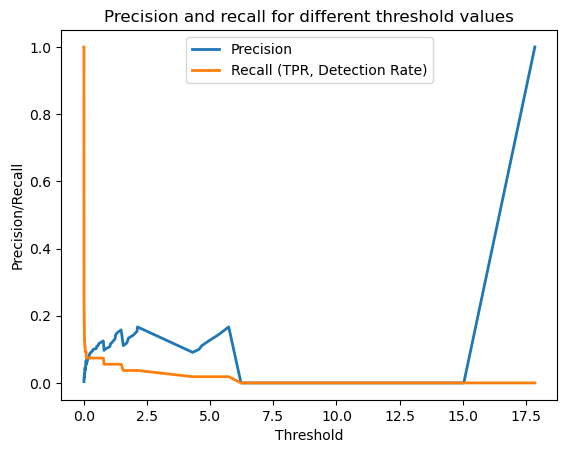

In [92]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(
    error_df_train.True_class, 
    error_df_train.Reconstruction_error
    )

plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:], label="Recall (TPR, Detection Rate)",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [93]:
THRESHOLD = 6

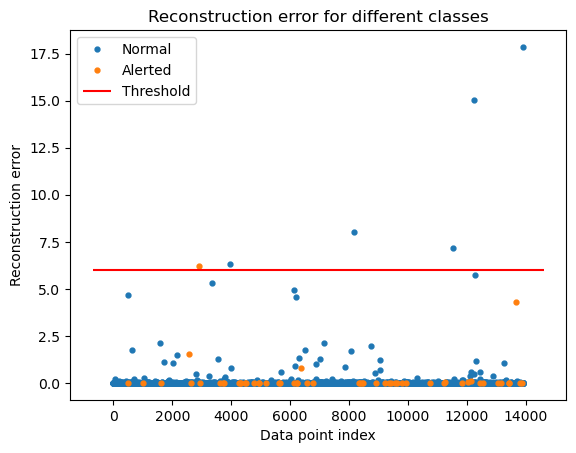

In [94]:
groups = error_df_train.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Alerted" if name == 1 else "Normal")
ax.hlines(THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [95]:
X_test_pred = autoencoder.predict(X_test)
Y_test_pred = [ True if (np.mean(np.power(X_test_pred[i] - X_test[i],2)) >= THRESHOLD) else False for i in range(len(X_test))]

435/435 [==============================] - 3s 6ms/step


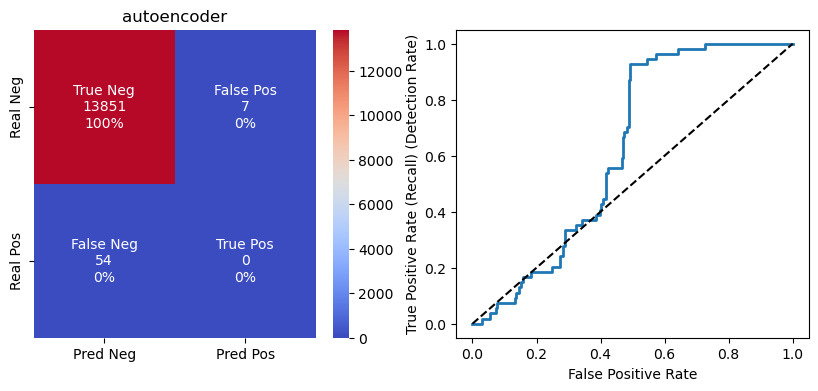

In [96]:
cf_matrix = confusion_matrix(Y_test, Y_test_pred)
name='autoencoder'

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = [ f'{value:0}' for value in cf_matrix.flatten()]
group_percentages = [f'{value*100:.0f}%' for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [ f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages) ]
labels = np.asarray(labels).reshape(2,2)
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="coolwarm", center = np.sum(cf_matrix)/2, xticklabels=["Pred Neg", "Pred Pos"], yticklabels=["Real Neg", "Real Pos"], ax=ax[0])
ax[0].set_title(name)

mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
fpr, tpr, thresholds = roc_curve(Y_test, mse)
# roc_curve_params[name] = [ fpr, tpr, thresholds ]

ax[1].plot(fpr, tpr, linewidth=2)
ax[1].plot([0,1], [0,1], 'k--')
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate (Recall) (Detection Rate)")
plt.show()